<a href="https://colab.research.google.com/github/hws2002/MachineLearning_PytorchNScikitLearn/blob/master/chapter13/chapter13_5_building_arch_with_torchnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 13.5 torch.nn모듈을 사용하여 일반적인 아키텍쳐 구현하기
`nn.Sequantial`클래스를 사용하여 피드포워드 신경망 모델을 만들어보자

In [1]:
import torch
import torch.nn as nn
model = nn.Sequential(
    nn.Linear(4,16),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU()
)

In [2]:
model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [3]:
# 각각의 Linear층의 가중치 초깃값의 분포를 설정하고
# 두번째 완전 연결 층의 가중치 행렬을 사용하여 L1페널티 항을 계산하자
nn.init.xavier_uniform_(model[0].weight)
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

## 13.5.2 손실 함수 선택하기
손실 함수의 선택은 문제에 따라 다름.  
예를 들어 회귀 문제를 위해서는 평균 제곱 오차 손실을 사용할 수 있고,  
크로스 엔트로피 손실 함수는 분류 작업에 사용할 수 있음.  
또한 문제에 적절한 측정 지표를 연결하여 사용해야 함.  

In [4]:
# 이번 장에서는 SGD 옵티마이저와 이진 분류를 위한 크로스 엔트로피 손실을 사용해보자
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

## 13.5.3 XOR 분류 문제 풀어보기
XOR 분류 문제는 두 개의 클래스 사이에서 비선형 결정 경계를 감지하는 모델의 수용 능력을 분석하기 위한 전통적인 문제임.  
먼저 [-1, 1) 사이의 균등 분포에서 뽑은 두개의 특성 (x0, x1)을 가진 200개의 훈련 샘플이 들어 있는 작은 데이터셋을 생성 후, 다음 규칙에 따라 훈련샘플i에 정답 레이블을 부여함.  
$y^{(i)} = \begin{cases}
0 & x_0^{(i)}\times x_1^{(i)} < 0 \\
1 & \text{otherwise}
\end{cases}$  
절반은 훈련에 사용하고 남은 절반은 검증에 사용해보자

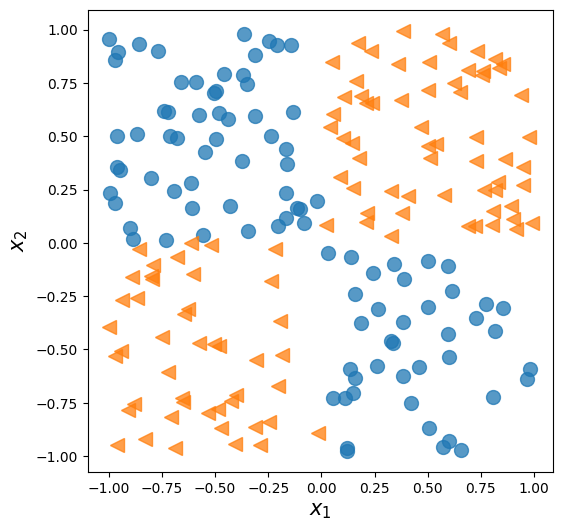

In [5]:
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(1)
np.random.seed(1)
x = np.random.uniform(low = -1,high = 1,size = (200,2))
y = np.ones(len(x))
y[x[:,0] * x[:,1] < 0] = 0
n_train = 100
x_train = torch.tensor(x[:n_train,:], dtype = torch.float32)
y_train = torch.tensor(y[:n_train], dtype = torch.float32)
x_valid = torch.tensor(x[:n_train,:], dtype = torch.float32)
y_valid = torch.tensor(y[:n_train], dtype = torch.float32)
fig = plt.figure(figsize = (6,6))
plt.plot(x[y==0,0], x[y==0,1], 'o', alpha = 0.75, markersize = 10)
plt.plot(x[y==1,0], x[y==1,1], '<', alpha = 0.75, markersize = 10)
plt.xlabel(r"$x_1$",size=15)
plt.ylabel(r"$x_2$",size=15)
plt.show()

In [6]:
# 간단한 단일층 신경망에서 시작해보자
model = nn.Sequential(
    nn.Linear(2,1),
    nn.Sigmoid()
)
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [7]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

In [8]:
# 데이터로더
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(2)
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [9]:
# epoch는 200번으로 하고 돌려보자
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
  loss_hist_train = [0]*num_epochs
  accuracy_hist_train = [0]*num_epochs
  loss_hist_valid = [0]*num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:,0]
      loss = loss_fn(pred,y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()
      is_correct = ((pred>=0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:,0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [10]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

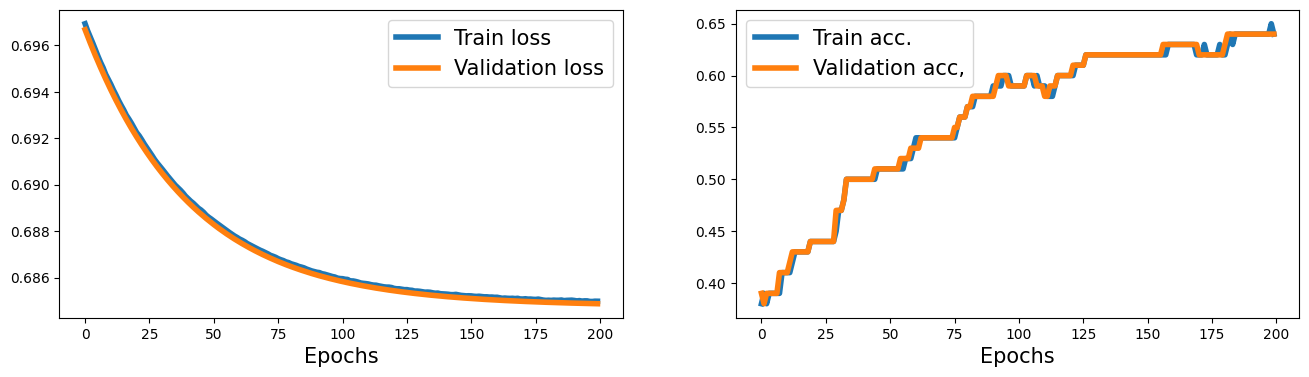

In [11]:
# 훈련 손실과  검증 손실, 훈련 정확도와 검증 정확도를 사용하여 학습 곡선을 그려 보자
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4, label = 'Train Loss')
plt.plot(history[1], lw=4, label = 'Validation Loss')
plt.legend(['Train loss','Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4, label = 'Train acc')
plt.plot(history[3], lw=4, label = 'Validation acc')
plt.legend(['Train acc.', 'Validation acc,'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

여기에서 볼 수 있듯이 은닉층이 없는 간단한 모델은 선형 결정 경계만 찾을 수 있음 -> XOR문제를 풀 수 없음.  
이로 인해 훈련 데이터셋과 검증 데이터셋의 손실이 매우 높고 분류 정확도는 매우 낮음.  
비선형 결정 경계를 찾기 위해 비선형 활성화 함수를 사용한 한개 이상의 은닉층을 추가할 수 있음.  
일반 근사 이론(Universal approximation theorem)에 의하면 하나의 은닉층과 매우 많은 은닉 유닛을 가진 피드포워드 신경망은 임의의 연속 함수를 비교적 잘 근사할 수 있음.  
따라서 XOR문제를 좀 더 만족스럽게 해결하는 한 가지 방법은 은닉층을 추가하고 검증 데이터셋에서 만족스러운 결과가 나올 때까지 은닉 유닛 개수를 바꾸면서 비교해 보는 것임(은닉 유닛을 늘린다 = 층의 폭을 넓힌다)  
또는 더 많은 은닉층을 추가하여 모델의 깊이를 깊게 할 수도 있음.  
네트워크의 폭 대신 깊이를 깊게 하면 비슷한 모델 수용 능력을 달성하는데 필요한 파라미터 개수가 적다는 장점이 있음.  
하지만 (넓은 모델에 비해) 깊은 모델은 그레디언트가 폭주하거나 소멸될 수 있어 훈련하기 어렵다는 단점또한 있음.  


In [12]:
# 예시를 위해 네 개의 은닉 유닛을 가진 한 개, 두 개, 세 개, 네 개의 은닉층을 추가해보자
# 우선 두 개의 은닉층으로 구성된 신경망의 결과를 봐보자
model = nn.Sequential(
    nn.Linear(2,4),
    nn.ReLU(),
    nn.Linear(4,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.Sigmoid()
)

In [13]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.015)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

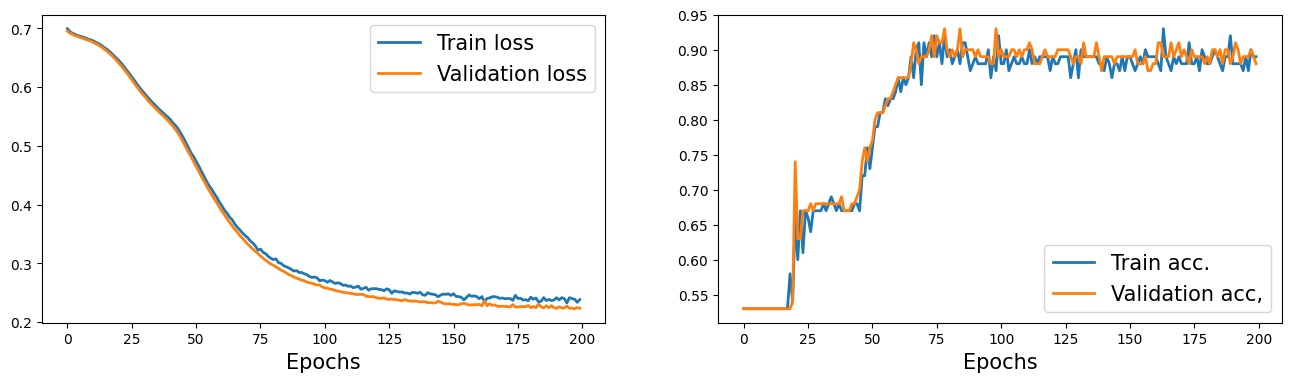

In [14]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=2, label = 'Train Loss')
plt.plot(history[1], lw=2, label = 'Validation Loss')
plt.legend(['Train loss','Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=2, label = 'Train acc')
plt.plot(history[3], lw=2, label = 'Validation acc')
plt.legend(['Train acc.', 'Validation acc,'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

## 13.5.4 nn.Module로 유연성이 높은 모델 만들기
Sequential 클래스로 여러 개의 층을 가진 완전 연결 신경망을 간편하게 만들었다. 하지만 안타깝게도 여러 개의 입력이나 출력을 가지거나 중간 가지(Branch)가 있는 복잡한 모델은 만들 수 없다.  그래서 nn.Module이 필요함.  

복잡한 모델을 만드는 방법은 nn.Module클래스를 상속하는 것.  
이때 `__init__()`생성자 메서드를 정의해야 하고, `forward()` 메서드를 사용하여 정방향 계산을 정의함.  
`__init__()`에서 클래스 속성으로 층을 정의해야 함. 이렇게 하면 `self` 식별자로 층을 참조할 수 있음.  
그리고 forward() 메서드에서 신경망의 정방향 계산에 이런 층들을 어떻게 사용할지 지정함.  


In [15]:
class MyModule(nn.Module):
  def __init__(self):
    super().__init__()
    l1 = nn.Linear(2,4)
    a1 = nn.ReLU()
    l2 = nn.Linear(4,4)
    a2 = nn.ReLU()
    l3 = nn.Linear(4,1)
    a3 = nn.Sigmoid()
    l = [l1,a1,l2,a2,l3,a3]
    self.module_list = nn.ModuleList(l)

  def forward(self, x):
    for f in self.module_list:
      x = f(x)
    return x

  def predict(self, x):
    x = torch.tensor(x, dtype = torch.float32)
    pred = self.forward(x)[:,0]
    return (pred>=0.5).float()

In [16]:
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [17]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.015)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

<ipython-input-18-0c4706facd18>:21: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  y = y_valid.numpy().astype(np.integer),


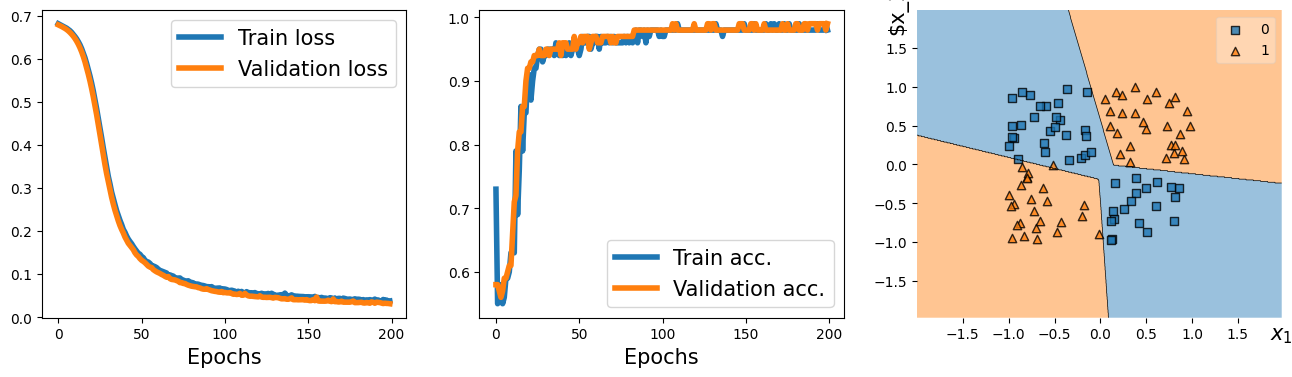

In [18]:
# 추가로 mlxtend 라이브러리를 사용하여 검증 데이터와 결정 경계를 시각화해보자

# 모델의 결정 경계를 계산하려면 MyModule 클래스에 predict() 메서드를 추가해야 함
import mlxtend
from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,3,1)
plt.plot(history[0], lw = 4)
plt.plot(history[1], lw = 4)
plt.legend(['Train loss', 'Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

ax = fig.add_subplot(1,3,2)
plt.plot(history[2], lw = 4)
plt.plot(history[3], lw = 4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

ax = fig.add_subplot(1,3,3)
plot_decision_regions(X = x_valid.numpy(),
                      y = y_valid.numpy().astype(np.integer),
                      clf = model)
ax.set_xlabel(r'$x_1$', size = 15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2', size = 15)
ax.yaxis.set_label_coords(-0.025, 1)


plt.show()

# 15.3.5 파이토치에서 사용자 정의 층 만들기
파이토치에서 제공하지 않는 층을 새로 정의해야 하는 경우 nn.Module 클래스를 상송하여 새로운 클래스를 정의할 수 있음.  
새로운 층을 만들거나 기존 층을 커스터마이징할 때 특히 유용함.  


In [20]:
#  w(x+e) + b 계산을 수행하는 NoisyLinear라는 층을 만들어 보자
class NoisyLinear(nn.Module):
  def __init__(self, input_size, output_size,
               noise_stddev = 0.1):
    super().__init__()
    w = torch.Tensor(input_size, output_size)
    self.w = nn.Parameter(w)
    nn.init.xavier_uniform_(self.w)
    b = torch.Tensor(output_size).fill_(0)
    self.b = nn.Parameter(b)
    self.noise_stddev = noise_stddev

  def forward(self, x, training = False):
    if training :
      noise = torch.normal(0.0, self.noise_stddev, x.shape)
      x_new = torch.add(x, noise)
    else :
      x_new = x
    return torch.add(torch.mm(x_new, self.w), self.b)


In [21]:
# 위 모듈의 인스턴스 객체를 만들고 입력 텐서에 전달하여 실행시켜보자
torch.manual_seed(1)
noisy_layer = NoisyLinear(4,2)
x = torch.zeros((1,4))
print(noisy_layer(x, training = True))
print(noisy_layer(x, training = True))
print(noisy_layer(x, training = False))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [22]:
# 이제 XOR 분류 문제를 풀기 위해 만들었던 모델과 비슷한 새로운 모델을 만들어 보자(NoisyLinear층을 첫 번째 은닉층으로 사용해서)
class MyNoisyModule(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 =  NoisyLinear(2,4,0.07)
    self.a1 = nn.ReLU()
    self.l2 = nn.Linear(4,4)
    self.a2 = nn.ReLU()
    self.l3 = nn.Linear(4,1)
    self.a3 = nn.Sigmoid()

  def forward(self, x, training = True):
    x = self.l1(x, training)
    x = self.a1(x)
    x = self.l2(x)
    x = self.a2(x)
    x = self.l3(x)
    x = self.a3(x)
    return x

  def predict(self, x):
    x = torch.tensor(x, dtype = torch.float32)
    pred = self.forward(x)[:,0]
    return (pred>=0.5).float()


In [24]:
torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [25]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.015)
torch.manual_seed(1)
loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
  for x_batch, y_batch in train_dl:
    pred = model(x_batch, True)[:,0]
    loss = loss_fn(pred,y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_hist_train[epoch] += loss.item()
    is_correct = (
        (pred >=0.5).float() == y_batch
    ).float()
    accuracy_hist_train[epoch] += is_correct.mean()
  loss_hist_train[epoch] /= n_train/batch_size
  accuracy_hist_train[epoch] /= n_train/batch_size
  pred = model(x_valid)[:,0]
  loss = loss_fn(pred, y_valid)
  loss_hist_valid[epoch] = loss.item()
  is_correct = ((pred>=0.5).float() == y_valid).float()
  accuracy_hist_valid[epoch] += is_correct.mean()


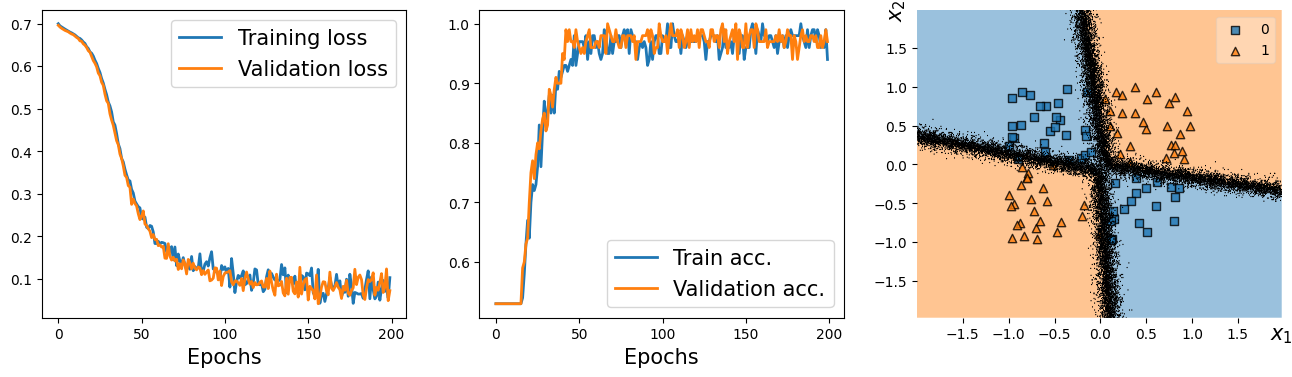

In [29]:
# 손실, 정확도, 결정 경계 그래프를 그려보자
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,3,1)
plt.plot(loss_hist_train, lw = 2)
plt.plot(loss_hist_valid, lw = 2)
plt.legend(['Training loss','Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs',size = 15)

ax = fig.add_subplot(1,3,2)
plt.plot(accuracy_hist_train, lw = 2)
plt.plot(accuracy_hist_valid, lw = 2)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,3,3)
plot_decision_regions(X = x_valid.numpy(),
                       y = y_valid.numpy().astype(np.int32),
                       clf = model)

ax.set_xlabel(r'$x_1$', size = 15)
ax.xaxis.set_label_coords(1,-0.025)
ax.set_ylabel(r'$x_2$', size = 15)
ax.yaxis.set_label_coords(-0.025,1)
plt.show()